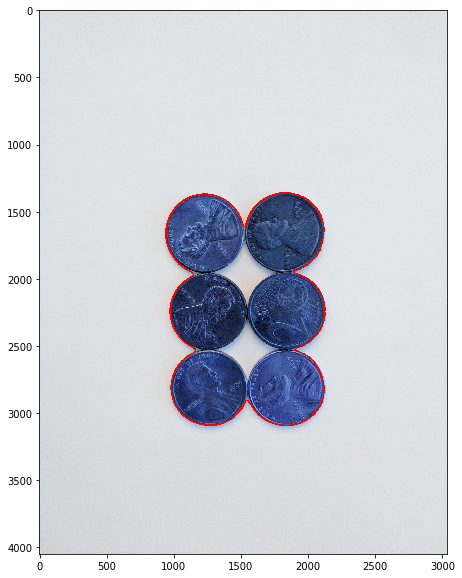

In [1]:
'''This algorithm is especially useful for segmenting images into 
background and foreground in situations that are difficult for other algorithms'''

#trying out with methods already covered
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


def display(image, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap='gray')
    
separated_coins  = cv2.imread('../DATA/pennies.jpg')

#Median blur
separated_coins_blur = cv2.medianBlur(separated_coins,25)
#convert to grayscale
separated_coins_gray = cv2.cvtColor(separated_coins_blur,cv2.COLOR_BGR2GRAY)
#appy binary threshold
ret, separated_coins_threshold = cv2.threshold(separated_coins_gray,160,255,
                                              cv2.THRESH_BINARY_INV)
#find contours
image, contours, heirachy =  cv2.findContours(separated_coins_threshold.copy(),
                                             cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if heirachy[0][i][3] == -1:
        cv2.drawContours(separated_coins,contours,i,(255,0,0),10)
        
display(separated_coins)

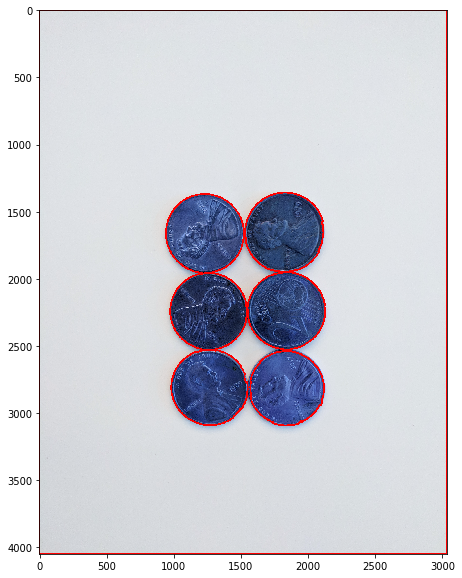

In [2]:
#Watershed Algorithm

#1. Read in image
separated_coins  = cv2.imread('../DATA/pennies.jpg')

#2. Apply blur
separated_coins_blur = cv2.medianBlur(separated_coins,35)
#3. Convert to grayscale
gray = cv2.cvtColor(separated_coins_blur,cv2.COLOR_BGR2GRAY)

#4 Apply threshold on grayscale image and Otsu's method
ret, threshold_image = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV
                                    +cv2.THRESH_OTSU)

#5. Noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(threshold_image,cv2.MORPH_OPEN,kernel,iterations=2)

#sure background
sure_bg = cv2.dilate(opening,kernel,iterations=3)

#6. apply distance transformation
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


#create objects you are sure of that are in the foreground

ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

#7. Calculate unknown region
sure_fg=np.uint8(sure_fg)
unknown_region = cv2.subtract(sure_bg,sure_fg)


#8. create the laber markers for the watershed algorithm
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown_region==255] = 0
markers = cv2.watershed(separated_coins,markers)

#find contours
image, contours, heirachy =  cv2.findContours(markers.copy(),
                                             cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if heirachy[0][i][3] == -1:
        cv2.drawContours(separated_coins,contours,i,(255,0,0),10)
        
display(separated_coins)

In [5]:
#Custon Seeds with Watershed Algorithm and Automatically segment them
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 



#import color mappings
from matplotlib import cm


road = cv2.imread('../DATA/road_image.jpg')
road_copy = road.copy()

marker_image = np.zeros(road.shape[:2],dtype=np.int32)
segments = np.zeros(road.shape, dtype=np.uint8)

def create_rgb(i):
    return tuple(np.array(cm.tab10(i)[:3])*255)

colors = []
for i in range(10):
    colors.append(create_rgb(i))

#Setup call-back function:

#global variables->color choice
current_marker = 1
n_markers = 10 #0-9
#check if markers are updated
marks_updated = False

#Callback function
def mouse_callback(event,x,y,flags,param):
    global marks_updated
    
    if event == cv2.EVENT_LBUTTONDOWN:
        #markers passed to the watershed algorithm
        cv2.circle(marker_image,(x,y),10,(current_marker),-1)
        #what the user sees on the road image
        cv2.circle(road_copy,(x,y),10,colors[current_marker],-1)
        marks_updated =True
        
        
#While True
cv2.namedWindow('Road Image')
cv2.setMouseCallback('Road Image',mouse_callback)

while True:
    #show the image
    cv2.imshow('Watershed Segments',segments)
    #show road image
    cv2.imshow('Road Image',road_copy)
    
    #Close all windows
    k = cv2.waitKey(1)
    if k == 27:
        break
        
    #Clear all colors by pressing the C key
    elif k == ord('c'):
        #reset the images
        road_copy = road.copy()
        marker_image = np.zeros(road.shape[:2],dtype=np.int32)
        segments = np.zeros(road.shape,dtype=np.uint8)
    
    #update colour choice
    elif k>0 and chr(k).isdigit():
        current_marker = int(chr(k))
        
    #Update the markings
    if marks_updated:
        marker_image_copy = marker_image.copy()
        cv2.watershed(road,marker_image_copy)
        
        segments = np.zeros(road.shape,dtype=np.uint8)
        
        for color_index in range(n_markers):
            #color segments through a numpy call
            segments[marker_image_copy==(color_index)] = colors[color_index]
            
cv2.destroyAllWindows()